In [81]:
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')

# Part 1: Data Preparation and Exploration

In [42]:
data=pd.read_csv("C:\\Users\\DELL\\Downloads\\DATASCIENCE ASSIGNMENTS\\exchange_rate.csv", parse_dates=['date'], index_col='date')
data.head()

,Ex_rate
date,
01-01-1990 00:00,0.7855
02-01-1990 00:00,0.7818
03-01-1990 00:00,0.7867
04-01-1990 00:00,0.7860
05-01-1990 00:00,0.7849


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7588 entries, 01-01-1990 00:00 to 10-10-2010 00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6+ KB


In [44]:
import matplotlib.pyplot as plt

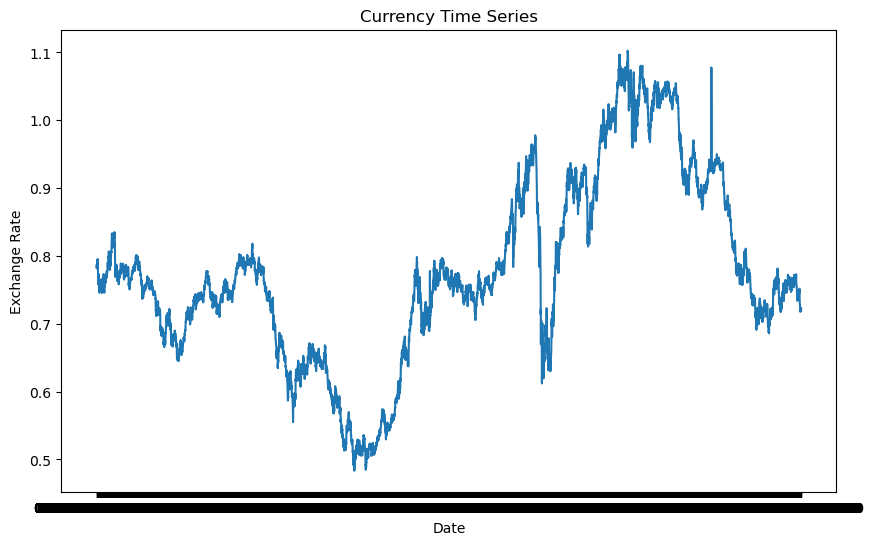

In [45]:
#time series plot
plt.figure(figsize=(10, 6))
plt.plot(data['Ex_rate'])
plt.title('Currency Time Series')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.show()

In [46]:
# Check for missing values
missing_values = data.isnull().sum()
print(missing_values)

Ex_rate    0
dtype: int64


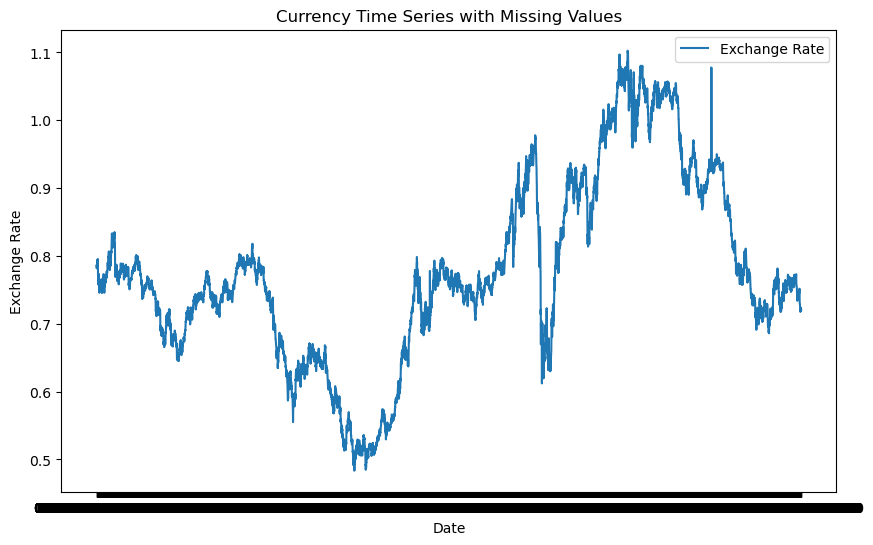

In [47]:
# Visualize missing values
plt.figure(figsize=(10, 6))
plt.plot(data['Ex_rate'], label='Exchange Rate')
plt.title('Currency Time Series with Missing Values')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [49]:
# Drop rows with any missing values
data_cleaned = data.dropna()

In [50]:
# Linear interpolation for time series data
data['Ex_rate'] = data['Ex_rate'].interpolate(method='linear')


In [52]:
# Capping outliers
import numpy as np
upper_limit = data['Ex_rate'].quantile(0.99)
lower_limit = data['Ex_rate'].quantile(0.01)

data['Ex_rate'] = np.where(data['Ex_rate'] > upper_limit, upper_limit,
                               np.where(data['Ex_rate'] < lower_limit, lower_limit, data['Ex_rate']))


# Part 2: Model Building - ARIMA

In [61]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [63]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    adf_test = adfuller(timeseries, autolag='AIC')
    adf_result = pd.Series(adf_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print(adf_result)
    if adf_result['p-value'] <= 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is not stationary; differencing is needed.")


In [65]:
# Test for stationarity
test_stationarity(data['Ex_rate'])

Test Statistic                   -1.644678
p-value                           0.459818
#Lags Used                        1.000000
Number of Observations Used    7586.000000
dtype: float64
The time series is not stationary; differencing is needed.


In [67]:
# Differencing to make the series stationary
data_diff = data['Ex_rate'].diff().dropna()

# Test again for stationarity after differencing
test_stationarity(data_diff)


Test Statistic                  -99.230607
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    7586.000000
dtype: float64
The time series is stationary.


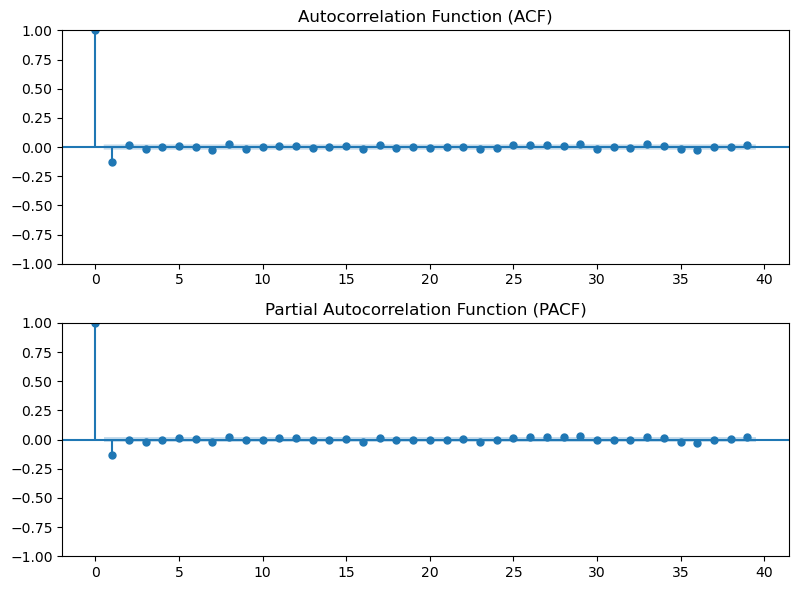

In [73]:
# Plot ACF and PACF for the differenced series
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

plot_acf(data_diff, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')

plot_pacf(data_diff, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


In [89]:
from statsmodels.tsa.arima.model import ARIMA
p = 1  
d = 1  
q = 1  
# Fit ARIMA model
model = ARIMA(data['Ex_rate'], order=(p, d, q))
results = model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28174.929
Date:                Tue, 27 Aug 2024   AIC                         -56343.859
Time:                        18:28:36   BIC                         -56323.056
Sample:                             0   HQIC                        -56336.720
                               - 7588                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1219      0.046     -2.648      0.008      -0.212      -0.032
ma.L1         -0.0080      0.046     -0.173      0.863      -0.098       0.082
sigma2      3.483e-05   1.01e-07    345.721      0.000    3.46e-05     3.5e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           2331465.94
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.81   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        88.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

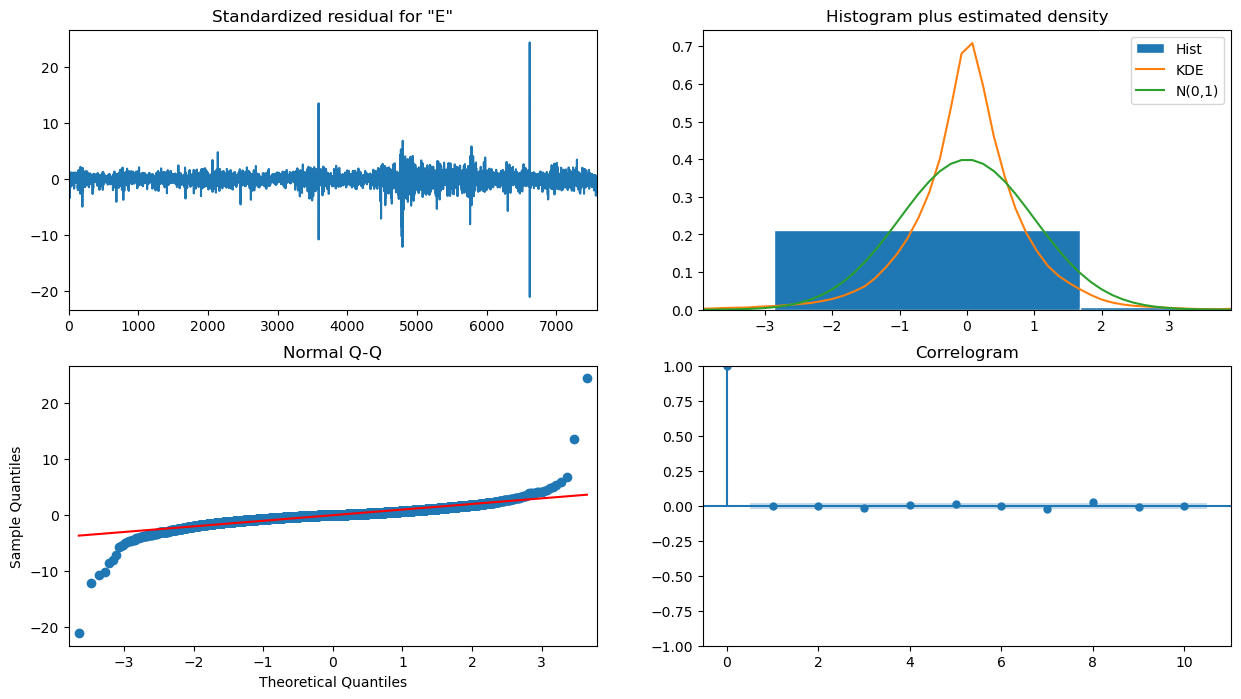

In [87]:
# Plot diagnostics
results.plot_diagnostics(figsize=(15, 8))
plt.show()


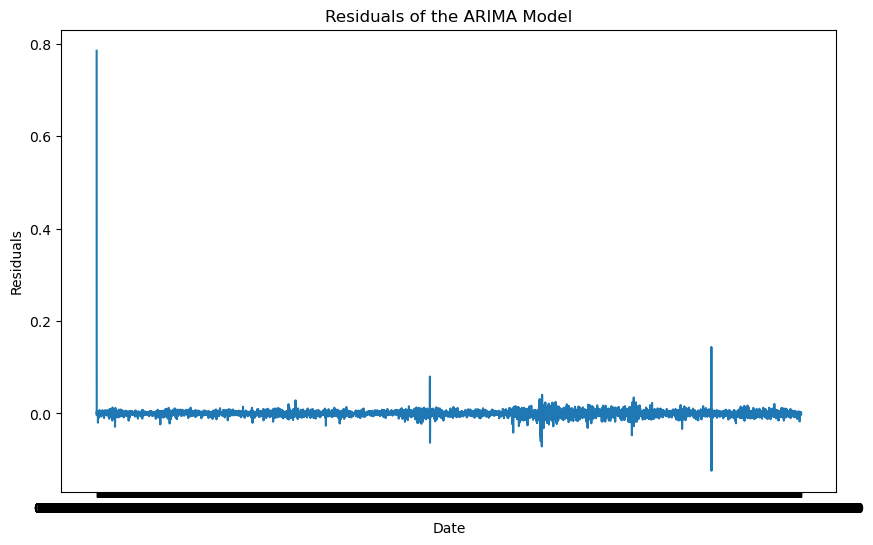

In [92]:
# Plot the residuals
residuals = results.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals of the ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()


In [98]:

train_size = int(len(data) * 0.8)  
train, test = data['Ex_rate'][:train_size], data['Ex_rate'][train_size:]


In [ ]:
forecast = results.get_forecast(steps=len(test))

# Get the predicted mean and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()


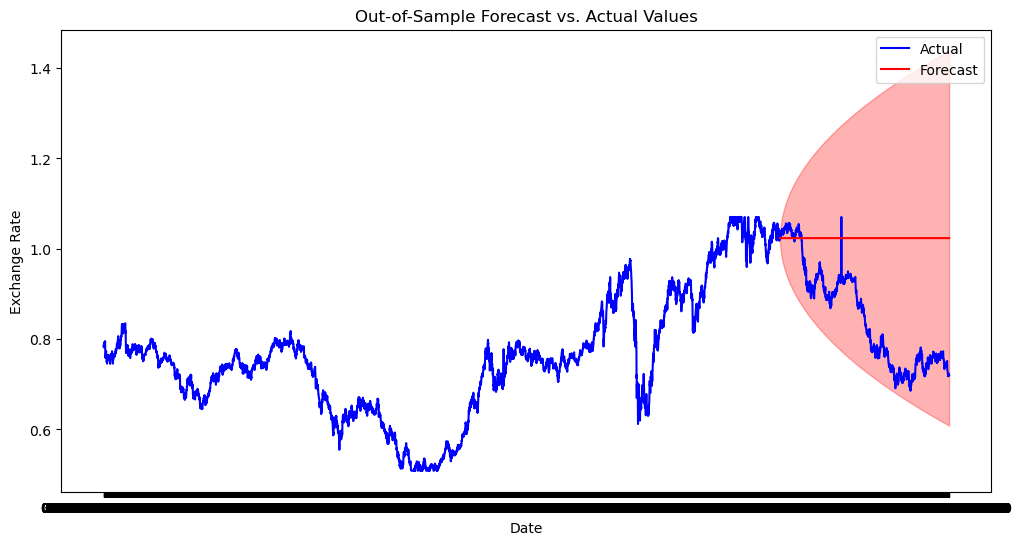

In [109]:
# Plot the actual values and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Ex_rate'], label='Actual', color='blue')
plt.plot(test.index, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='red', alpha=0.3)

plt.title('Out-of-Sample Forecast vs. Actual Values')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()


# Part 3: Model Building - Exponential Smoothing2

In [115]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

model = SimpleExpSmoothing(data['Ex_rate'])
fitted_model = model.fit()
fitted_model.summary()

Dep. Variable:,Ex_rate,No. Observations:,7588
Model:,SimpleExpSmoothing,SSE,0.264
Optimized:,True,AIC,-77886.745
Trend:,None,BIC,-77872.876
Seasonal:,None,AICC,-77886.740
Seasonal Periods:,None,Date:,"Tue, 27 Aug 2024"
Box-Cox:,False,Time:,21:20:59
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8699552,alpha,True
initial_level,0.7855000,l.0,False


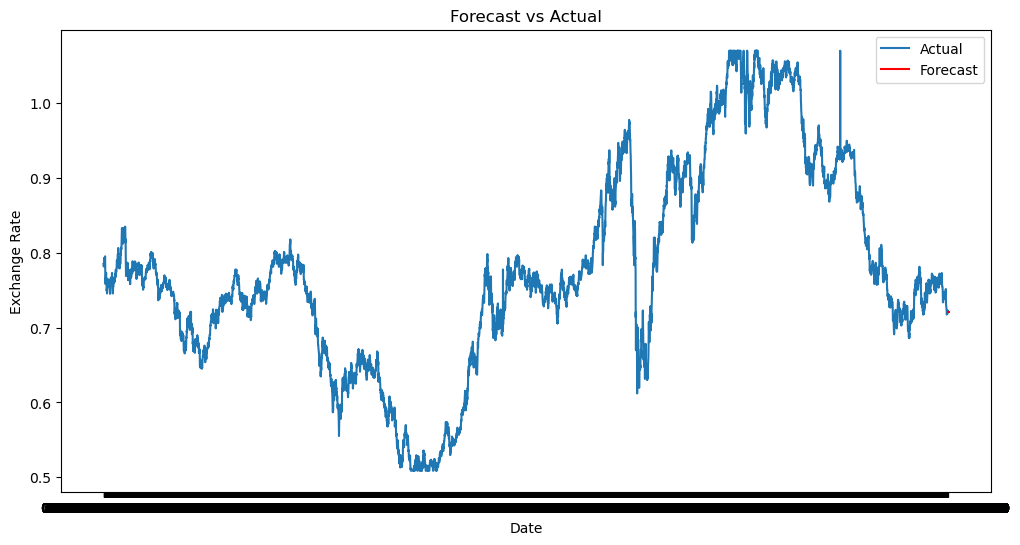

In [119]:
forecast = fitted_model.forecast(steps=12)

# Plot the forecast against the actual data
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Ex_rate'], label='Actual')
plt.plot(forecast.index, forecast, label='Forecast', color='red')
plt.title('Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()


# Part 4: Evaluation and Comparison

In [124]:

actual = data['Ex_rate'][-12:] 

In [132]:
forecast = fitted_model.forecast(steps=12)
actual = data['Ex_rate'][-12:]
print(len(forecast))  
print(len(actual))    


12
12


In [138]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(actual, forecast)
mse = mean_squared_error(actual, forecast)
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')



MAE: 0.0016761444809646753
RMSE: 0.002007067896446248
